In [1]:
#lib imports
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#local imports
from utils import *
from plotting import *
from model_creator import *

print('TensorFlow version: ', tf.__version__)
print('Python version: ', os.sys.version)

TensorFlow version:  2.18.0
Python version:  3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:42:31) [MSC v.1937 64 bit (AMD64)]


In [2]:
model = build_large_unet_model(input_shape=(128, 128, 3))
tf.keras.utils.plot_model(model, to_file='model.png', rankdir='')

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [3]:
from tensorflow.keras.utils import normalize
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_data(image_dir, mask_dir, target_size=(128, 128)):
    images = []
    masks = []
    
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        img = load_img(img_path, target_size=target_size)
        img = img_to_array(img) / 255.0 
        assert img.shape == target_size + (3,)
        images.append(img)
        
        mask_path = os.path.join(mask_dir, mask_file)
        mask = load_img(mask_path, target_size=target_size, color_mode="grayscale")
        mask = img_to_array(mask)
        mask = mask / 255.0  
        assert mask.shape == target_size + (1,)
        masks.append(mask)
        
    print('Loaded', len(images), 'images')
    print('Loaded', len(masks), 'masks')
    
    images = np.array(images)
    masks = np.array(masks)
    
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    images = images[indices]
    masks = masks[indices]
    
    return images, masks

In [4]:
def visualize_mask_and_image(images, masks, num_samples=5):
    num_samples = min(num_samples, len(images))
    
    plt.figure(figsize=(12, num_samples * 4))
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))

        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(images[idx]) 
        plt.title(f"Image {idx}")
        plt.axis("off")

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(masks[idx].squeeze(), cmap="gray") 
        plt.title(f"Mask {idx}")
        plt.axis("off")

Loaded 1199 images
Loaded 1199 masks


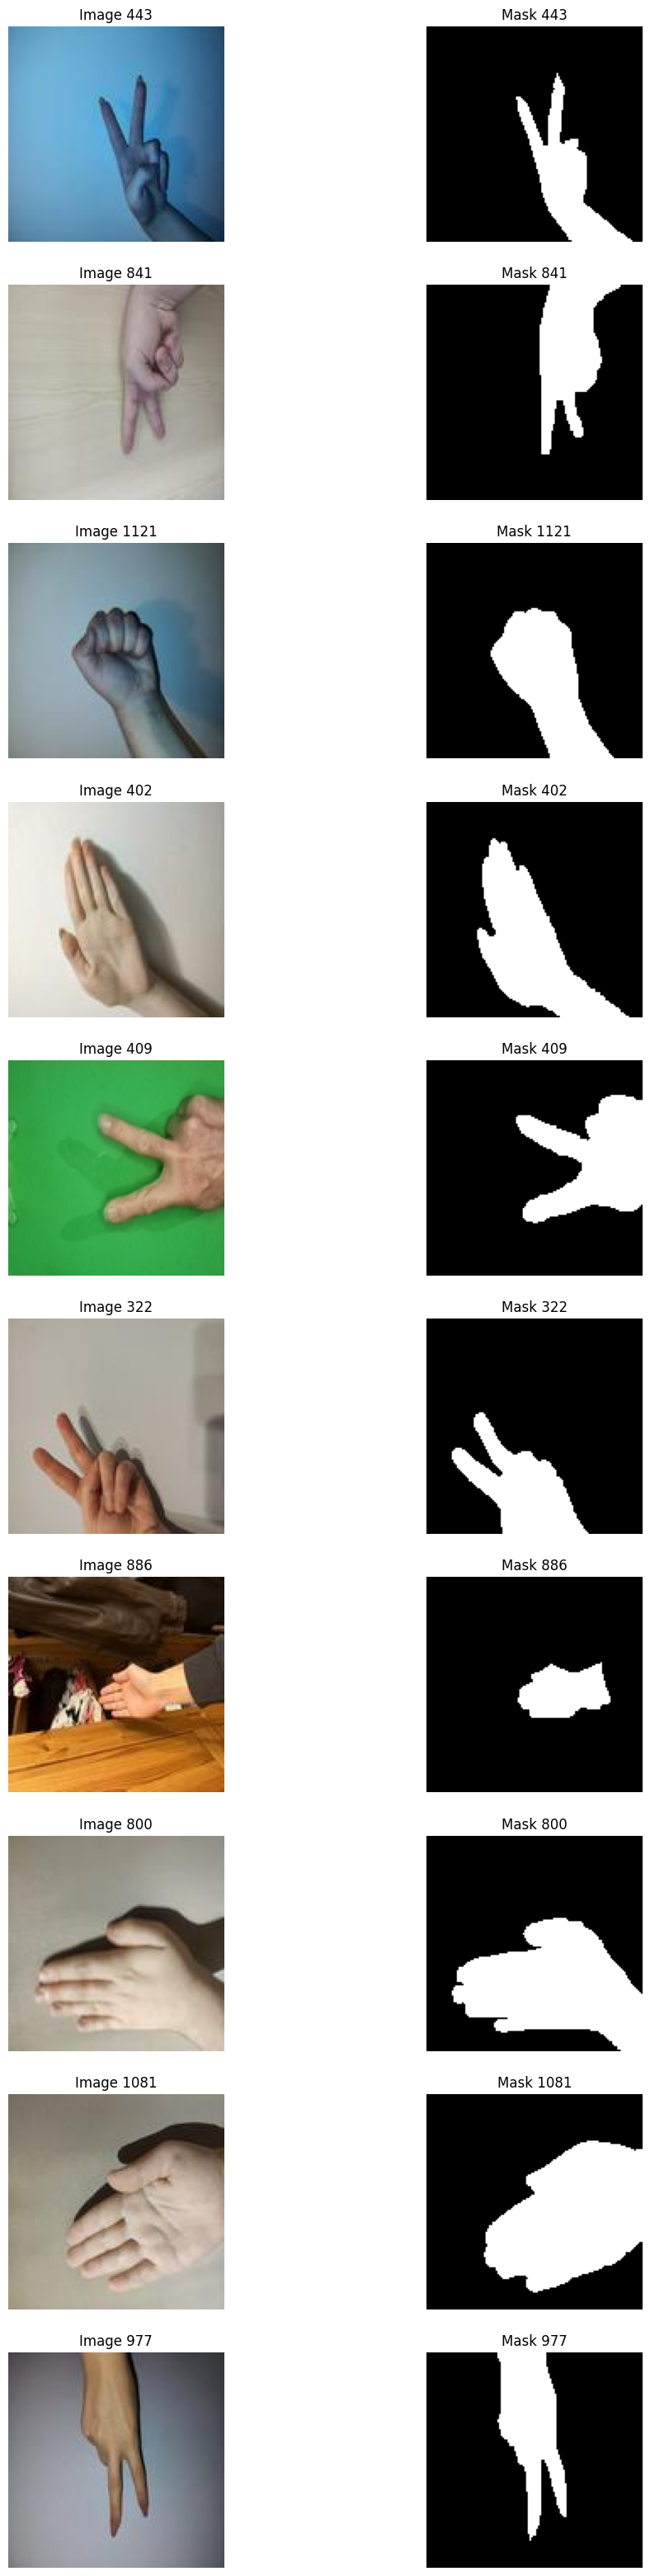

In [5]:
local_dir = './'
images_dir = os.path.join(local_dir, 'unet_utils/unet_supervisely_dataset_processing/ds_supervisely/img')
masks_dir = os.path.join(local_dir, 'unet_utils/unet_supervisely_dataset_processing/processed_masks')
assert os.path.exists(images_dir), f'Image directory not found: {images_dir}'
assert os.path.exists(masks_dir), f'Masks directory not found: {masks_dir}'
assert len(os.listdir(images_dir)) == len(os.listdir(masks_dir)), 'Number of images and masks do not match'

models_dir = os.path.join(local_dir, 'models_segmantation')
os.makedirs(models_dir, exist_ok=True)

X, y = load_data(images_dir, masks_dir, target_size=(128, 128))

visualize_mask_and_image(X, y, num_samples=10)

In [6]:
EPOCHS = 20
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.1
MODEL_NAME = 'unet_segmentation_large'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(models_dir, f'{MODEL_NAME}_ckp.keras'),
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

csvlogger_callback = tf.keras.callbacks.CSVLogger(
    filename=os.path.join(models_dir, f'{MODEL_NAME}_ckp_history.csv'),     
    separator=',',                      
    append=True                           
)
history = model.fit(X, y,
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_split=VALIDATION_SPLIT, 
                    callbacks=[checkpoint_callback, csvlogger_callback])
save_model(model, MODEL_NAME, models_dir, history.history)


Epoch 1/20


c:\Users\adria\anaconda3\envs\ML\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


68/68 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - acc: 0.7598 - loss: 0.4462 - val_acc: 0.4935 - val_loss: 5.4613
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - acc: 0.9199 - loss: 0.2074 - val_acc: 0.8837 - val_loss: 0.2551
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - acc: 0.9384 - loss: 0.1569 - val_acc: 0.8945 - val_loss: 0.2589
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - acc: 0.9492 - loss: 0.1300 - val_acc: 0.9295 - val_loss: 0.1655
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - acc: 0.9580 - loss: 0.1123 - val_acc: 0.9441 - val_loss: 0.1364
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - acc: 0.9602 - loss: 0.1022 - val_acc: 0.9664 - val_loss: 0.0895
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - acc: 0.9707 - loss: 0.0781 - val_acc: 0.9564 - val_loss: 0.1168
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - acc: 0.9709 - loss: 0.0774 - val_acc: 0.9692 - val_loss: 0.0834
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - acc: 0.9756 - loss: 0.0644 - va

<Figure size 640x480 with 0 Axes>

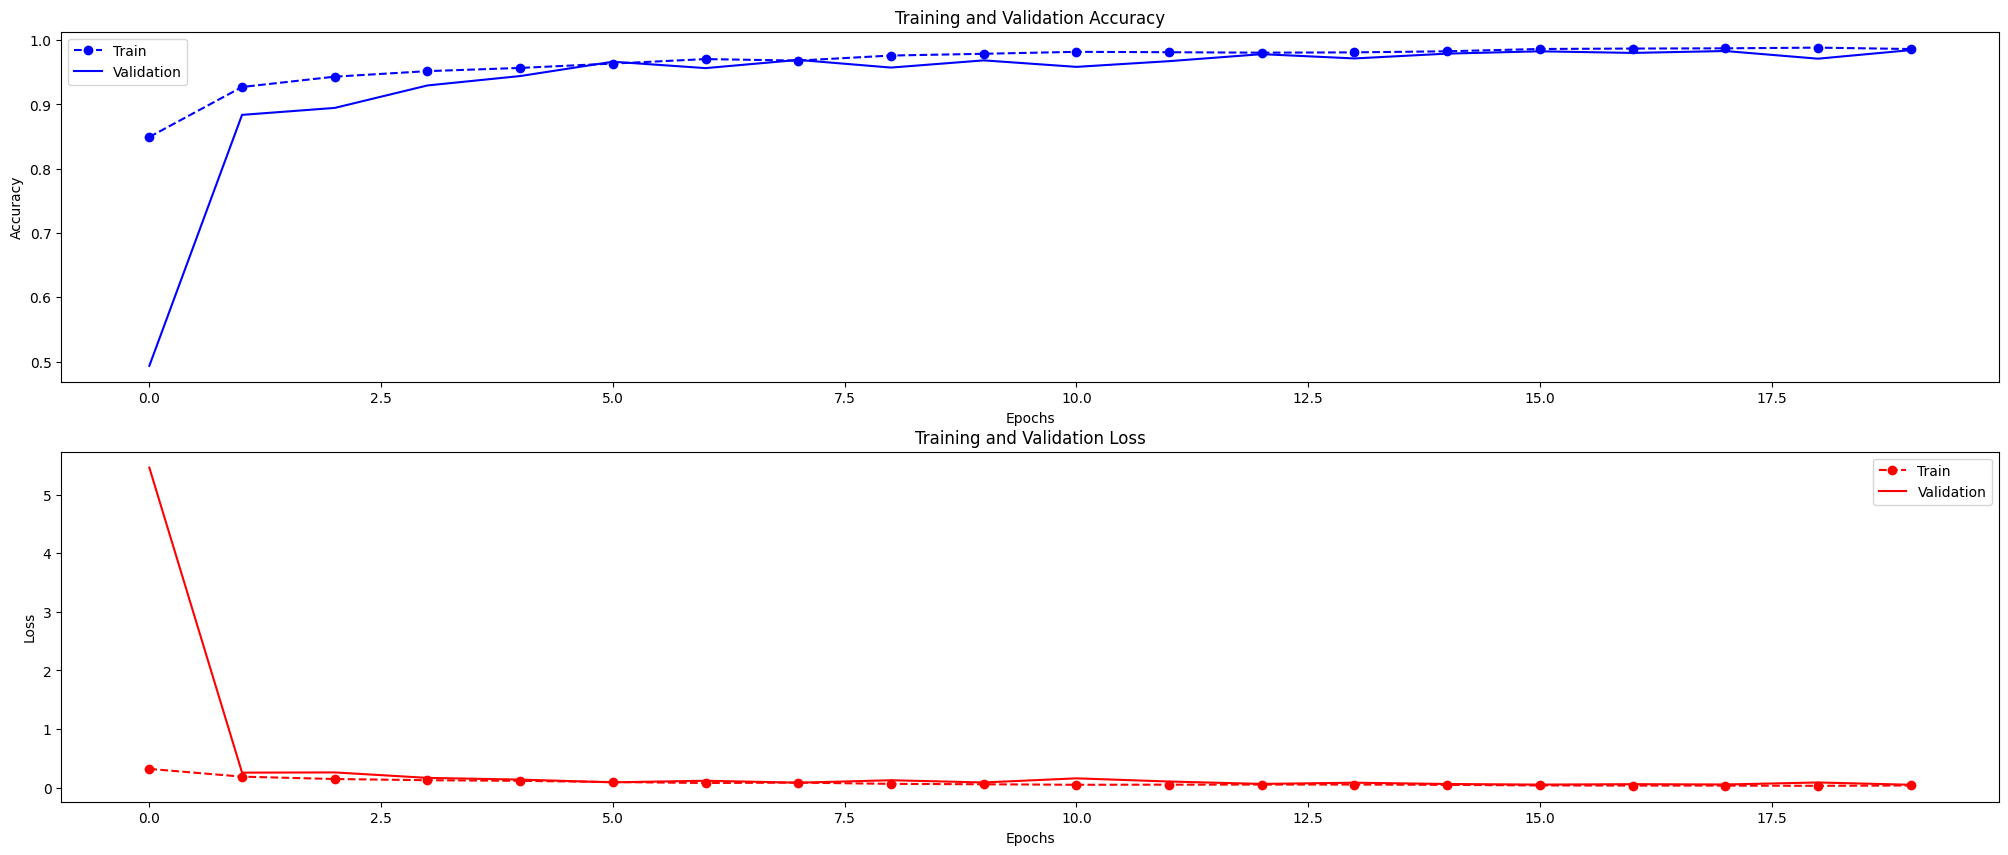

In [8]:
from plotting import plot_history_csv
csv_file = os.path.join(models_dir, f'{MODEL_NAME}_ckp_history.csv')
plot_history_csv(csv_file)